<a href="https://colab.research.google.com/github/divyakumar-cloud/Divya/blob/master/FMADRL_PP_Research_CHF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#  Mount Drive and Create Directory Structure
from google.colab import drive
import os
import sys
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
 # Mount Google Drive
drive.mount('/content/drive')
 # Create comprehensive project structure
base_path = '/content/drive/MyDrive/FMARL_PP_Research_CHF'
# List of directories to create
directories = [
    'src/core', 'src/agents', 'src/privacy', 'src/federated',
    'src/evaluation', 'src/utils', 'data/synthetic', 'data/real',
    'models/checkpoints', 'models/trained', 'results/experiments',
    'results/figures', 'papers/drafts', 'papers/final',
    'notebooks/development', 'notebooks/experiments'
]
 # Create directories if they don't exist
for dir_path in directories:
    os.makedirs(os.path.join(base_path, dir_path), exist_ok=True)
 # Add src folder to Python path
sys.path.append(os.path.join(base_path, 'src'))

print("✅ Directory structure created successfully!")
print(f" Base path: {base_path}")

Mounted at /content/drive
✅ Directory structure created successfully!
 Base path: /content/drive/MyDrive/FMARL_PP_Research_CHF


### **Step 1: Install Required Packages**



In [ ]:
# Step 1: Install Required Packages
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q stable-baselines3[extra] gymnasium
!pip install -q tenseal diffprivlib cryptography==44.0.3
!pip install --upgrade pydrive2 pyopenssl
!pip install -q protobuf>=5.29.1
!pip install -q flwr ray[default]
!pip install -q pandas numpy scipy matplotlib seaborn plotly
!pip install -q networkx simpy faker
!pip install -q tqdm psutil memory-profiler
!pip install -q wandb tensorboard
!pip install -q scikit-learn umap-learn

# Verify installations
import torch
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 73.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.9/176.9 kB 16.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pydrive2 1.21.3 requires cryptography<44, but you have cryptography 44.0.3 which is incompatible.
pyopenssl 24.2.1 requires cryptography<44,>=41.0.5, but you have cryptography 44.0.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 72.5 MB/s eta 0:00:00
  Attempting uninstall: cryptography
    Found existing installation: cryptography 44.0.3
    Uninstalling cryptography-44.0.3:
      Successfully uninstalled cryptography-44.0.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 703

**Step 2: Imports & Utility Configuration**

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple
from typing import Dict, List, Tuple, Any, Optional
import time
from enum import Enum
import pickle
import json
import gc
import psutil


**Step 3: Core Configurations**

In [ ]:
# Scaling configs
SCALING_CONFIGS = {
    5:  {'episodes': 200, 'batch_size': 32,  'hidden_dims': [64, 32],   'buffer_size': 5000},
    10: {'episodes': 300, 'batch_size': 64,  'hidden_dims': [128, 64],  'buffer_size': 10000},
    50: {'episodes': 500, 'batch_size': 128, 'hidden_dims': [256, 128], 'buffer_size': 25000},
    100: {'episodes': 800,'batch_size': 256, 'hidden_dims': [512, 256], 'buffer_size': 50000}
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


 **Step 4: Sensor Simulation**

In [ ]:
class SensorBehaviorType(Enum):
    CONTINUOUS_HIGH_FREQ = "continuous_hf"

class SensorConfiguration:
    def __init__(self, behavior_type, sensors_per_agent=2, sampling_rate=100.0, data_range=(-10.0, 10.0), noise_std=0.1, drift_rate=0.01):
        self.behavior_type = behavior_type
        self.sensors_per_agent = sensors_per_agent
        self.sampling_rate = sampling_rate
        self.data_range = data_range
        self.noise_std = noise_std
        self.drift_rate = drift_rate

class ContinuousHighFreqSensor:
    def __init__(self, sensor_id, config):
        self.sensor_id = sensor_id
        self.config = config
        self.current_value = np.random.uniform(*config.data_range)
        self.time_step = 0
        self.frequency_component = np.random.uniform(0.1, 0.3)
        self.amplitude = np.random.uniform(0.5, 2.0)
    def generate_sample(self, external_influence = 0.0):
        base_signal = (
            self.amplitude * np.sin(2 * np.pi * self.frequency_component * self.time_step * 0.1) +
            0.3 * np.sin(2 * np.pi * self.frequency_component * 2 * self.time_step * 0.1) +
            0.1 * np.sin(2 * np.pi * self.frequency_component * 3 * self.time_step * 0.1)
        )
        temporal_noise = 0.7 * np.random.normal(0, self.config.noise_std)
        drift = np.random.normal(0, self.config.drift_rate)
        value = self.current_value * 0.9 + base_signal + temporal_noise + drift + external_influence
        value = np.tanh(value / (self.config.data_range[1] - self.config.data_range[0])) * (self.config.data_range[1] - self.config.data_range[0])
        self.current_value = value
        self.time_step += 1
        return float(value)

class IoTDevice:
    def __init__(self, device_id, num_sensors=2):
        self.device_id = device_id
        self.config = SensorConfiguration(SensorBehaviorType.CONTINUOUS_HIGH_FREQ)
        self.sensors = {f"{device_id}_sensor_{i}": ContinuousHighFreqSensor(f"{device_id}_sensor_{i}", self.config) for i in range(num_sensors)}
        self.location = np.random.uniform(-1, 1, 2)
        self.neighbors = []
    def step(self, external_influences=None):
        readings = {sid: sensor.generate_sample((external_influences or {}).get(sid, 0.0)) for sid, sensor in self.sensors.items()}
        return readings
    def get_state_vector(self):
        readings = self.step()
        values = list(readings.values())
        derivatives = [sensor.current_value - sensor.amplitude for sensor in self.sensors.values()]
        features = values + derivatives + self.location.tolist() + [len(self.neighbors) / 10.0, (np.mean([sensor.time_step for sensor in self.sensors.values()]) % 100) / 100.0]
        return np.array(features, dtype=np.float32)


**Step 5: MADDPG Agent Networks**

In [ ]:
class BehavioralActorNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims):
        super().__init__()
        layers = []
        prev_dim = state_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.LayerNorm(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.1))
            prev_dim = h
        layers.extend([nn.Linear(prev_dim, action_dim), nn.Tanh()])
        self.network = nn.Sequential(*layers)
    def forward(self, state):
        return self.network(state)

class BehavioralCriticNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims):
        super().__init__()
        self.state_branch = nn.Sequential(nn.Linear(state_dim, hidden_dims[0]), nn.LayerNorm(hidden_dims[0]), nn.ReLU())
        combined_dim = hidden_dims[0] + action_dim
        layers = []
        prev_dim = combined_dim
        for h in hidden_dims[1:]:
            layers.extend([nn.Linear(prev_dim, h), nn.LayerNorm(h), nn.ReLU(), nn.Dropout(0.1)])
            prev_dim = h
        layers.append(nn.Linear(prev_dim, 1))
        self.q_network = nn.Sequential(*layers)
    def forward(self, state, action):
        state_feat = self.state_branch(state)
        x = torch.cat([state_feat, action], dim=1)
        return self.q_network(x)


**Step 6: Experience Replay Buffer**

In [ ]:
Experience = namedtuple('Experience', ['state', 'action', 'reward', 'next_state', 'done'])
class PrioritizedReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        self.priorities = deque(maxlen=capacity)
    def add(self, *args):
        self.buffer.append(Experience(*args))
        self.priorities.append(1.0)
    def sample(self, batch_size, beta=0.4):
        priorities = np.array(self.priorities)
        probabilities = priorities / np.sum(priorities)
        indices = np.random.choice(len(self.buffer), min(batch_size, len(self.buffer)), p=probabilities)
        experiences = [self.buffer[idx] for idx in indices]
        weights = (len(self.buffer) * probabilities[indices]) ** (-beta)
        weights /= weights.max()
        return experiences, indices, weights
    def update_priorities(self, indices, errors):
        for idx, err in zip(indices, errors):
            self.priorities[idx] = abs(err) + 1e-6
    def __len__(self):
        return len(self.buffer)


## **Step 7: DP+HE+SECURE AGGREGATION**

**ENHANCED DIFFERENTIAL PRIVACY**

In [ ]:
from diffprivlib.mechanisms import Laplace, Gaussian
class EnhancedDifferentialPrivacy:
    """Enhanced differential privacy with budget management and noise calibration"""

    def __init__(self, epsilon: float = 1.0, delta: float = 1e-5, composition_type: str = "advanced"):
        self.epsilon = epsilon
        self.delta = delta
        self.composition_type = composition_type
        self.privacy_budget_used = 0.0
        self.total_queries = 0
        self.composition_history = []

        # Sensitivity calibration for different data types
        self.sensitivity_map = {
            'gradients': 2.0,
            'model_params': 1.5,
            'sensor_data': 1.0,
            'aggregation': 0.5
        }

    def add_noise_to_gradients(self, gradients: torch.Tensor,
                              data_type: str = 'gradients',
                              clipping_norm: float = 1.0) -> torch.Tensor:
        """Add calibrated DP noise to gradients with gradient clipping"""

        # Gradient clipping for bounded sensitivity
        gradient_norm = torch.norm(gradients)
        if gradient_norm > clipping_norm:
            gradients = gradients * (clipping_norm / gradient_norm)

        sensitivity = self.sensitivity_map[data_type]

        if self.delta == 0:  # Pure DP
            scale = sensitivity / self.epsilon
            noise = torch.from_numpy(
                np.random.laplace(0, scale, gradients.shape)
            ).float().to(gradients.device)
        else:  # Approximate DP (Gaussian mechanism)
            sigma = np.sqrt(2 * np.log(1.25 / self.delta)) * sensitivity / self.epsilon
            noise = torch.normal(0, sigma, gradients.shape).to(gradients.device)

        noisy_gradients = gradients + noise
        self._update_privacy_budget(self.epsilon, data_type)

        return noisy_gradients

    def add_noise_to_model_params(self, model_params: Dict[str, torch.Tensor],
                                 noise_multiplier: float = 0.1) -> Dict[str, torch.Tensor]:
        """Add DP noise to model parameters before sharing"""

        noisy_params = {}
        epsilon_per_param = self.epsilon / len(model_params)

        for name, param in model_params.items():
            sensitivity = self.sensitivity_map['model_params']
            sigma = sensitivity * noise_multiplier / epsilon_per_param

            noise = torch.normal(0, sigma, param.shape).to(param.device)
            noisy_params[name] = param + noise

            self._update_privacy_budget(epsilon_per_param, 'model_params')

        return noisy_params

    def _update_privacy_budget(self, epsilon_used: float, query_type: str):
        """Update privacy budget with composition tracking"""

        if self.composition_type == "basic":
            self.privacy_budget_used += epsilon_used
        elif self.composition_type == "advanced":
            # Advanced composition (tighter bounds)
            self.privacy_budget_used += epsilon_used * np.sqrt(8 * np.log(1/self.delta))

        self.total_queries += 1
        self.composition_history.append({
            'query_type': query_type,
            'epsilon_used': epsilon_used,
            'timestamp': time.time()
        })

    def get_privacy_budget_remaining(self) -> float:
        """Get remaining privacy budget"""
        max_budget = 10.0  # Total allowable privacy budget
        return max(0, max_budget - self.privacy_budget_used)

    def reset_budget(self):
        """Reset privacy budget (new time period)"""
        self.privacy_budget_used = 0.0
        self.total_queries = 0
        self.composition_history = []

**CKKS HOMOMORPHIC ENCRYPTION MODULE**

In [ ]:
import tenseal as ts
class CKKSEncryptionManager:
    """Complete CKKS homomorphic encryption for federated learning"""

    def __init__(self, poly_modulus_degree: int = 8192,
                 coeff_mod_bit_sizes: List[int] = None,
                 scale: float = 2**40):

        if coeff_mod_bit_sizes is None:
            coeff_mod_bit_sizes = [60, 40, 40, 60]

        # Create TenSEAL context
        self.context = ts.context(
            ts.SCHEME_TYPE.CKKS,
            poly_modulus_degree=poly_modulus_degree,
            coeff_mod_bit_sizes=coeff_mod_bit_sizes
        )

        self.context.generate_galois_keys()
        self.context.global_scale = scale
        self.scale = scale

        print(f"✅ CKKS Context initialized:")
        print(f"   Poly modulus degree: {poly_modulus_degree}")
        print(f"   Global scale: {scale}")

    def encrypt_model_parameters(self, model_state_dict: Dict[str, torch.Tensor]) -> Dict[str, ts.CKKSVector]:
        """Encrypt model parameters using CKKS"""

        encrypted_params = {}

        for layer_name, params in model_state_dict.items():
            if isinstance(params, torch.Tensor):
                # Convert to numpy and flatten
                param_array = params.cpu().detach().numpy().flatten()

                try:
                    # Encrypt using CKKS
                    encrypted_tensor = ts.ckks_vector(self.context, param_array.tolist())
                    encrypted_params[layer_name] = encrypted_tensor

                except Exception as e:
                    print(f"⚠️ Failed to encrypt {layer_name}: {e}")
                    # Store as plaintext if encryption fails (fallback)
                    encrypted_params[layer_name] = param_array

        return encrypted_params

    def decrypt_model_parameters(self, encrypted_params: Dict[str, ts.CKKSVector],
                               original_shapes: Dict[str, torch.Size]) -> Dict[str, torch.Tensor]:
        """Decrypt CKKS encrypted parameters"""

        decrypted_params = {}

        for layer_name, encrypted_param in encrypted_params.items():
            try:
                if isinstance(encrypted_param, ts.CKKSVector):
                    # Decrypt CKKS vector
                    decrypted_array = np.array(encrypted_param.decrypt())

                    # Reshape back to original shape
                    if layer_name in original_shapes:
                        original_shape = original_shapes[layer_name]
                        expected_size = np.prod(original_shape)

                        if len(decrypted_array) >= expected_size:
                            decrypted_array = decrypted_array[:expected_size]
                            decrypted_tensor = torch.FloatTensor(decrypted_array)
                            decrypted_tensor = decrypted_tensor.reshape(original_shape)
                            decrypted_params[layer_name] = decrypted_tensor
                        else:
                            print(f"⚠️ Size mismatch for {layer_name}")
                            decrypted_params[layer_name] = torch.zeros(original_shape)
                else:
                    # Already plaintext
                    decrypted_params[layer_name] = torch.FloatTensor(encrypted_param)

            except Exception as e:
                print(f"⚠️ Failed to decrypt {layer_name}: {e}")
                # Use zero tensor as fallback
                if layer_name in original_shapes:
                    decrypted_params[layer_name] = torch.zeros(original_shapes[layer_name])

        return decrypted_params

    def homomorphic_average(self, encrypted_params_list: List[Dict[str, ts.CKKSVector]]) -> Dict[str, ts.CKKSVector]:
        """Compute homomorphic average of encrypted parameters"""

        if not encrypted_params_list:
            return {}

        num_clients = len(encrypted_params_list)
        averaged_params = {}

        # Initialize with first client's parameters
        for layer_name in encrypted_params_list[0].keys():
            if isinstance(encrypted_params_list[0][layer_name], ts.CKKSVector):
                averaged_params[layer_name] = encrypted_params_list[0][layer_name]
            else:
                # Handle plaintext case
                averaged_params[layer_name] = encrypted_params_list[0][layer_name] / num_clients

        # Add remaining clients' parameters (homomorphically)
        for client_params in encrypted_params_list[1:]:
            for layer_name in client_params.keys():
                if isinstance(averaged_params[layer_name], ts.CKKSVector):
                    try:
                        # Homomorphic addition
                        averaged_params[layer_name] += client_params[layer_name]
                    except Exception as e:
                        print(f"⚠️ Homomorphic addition failed for {layer_name}: {e}")
                else:
                    # Plaintext addition
                    averaged_params[layer_name] += client_params[layer_name] / num_clients

        # Divide by number of clients (homomorphically)
        for layer_name in averaged_params.keys():
            if isinstance(averaged_params[layer_name], ts.CKKSVector):
                try:
                    averaged_params[layer_name] *= (1.0 / num_clients)
                except Exception as e:
                    print(f"⚠️ Homomorphic division failed for {layer_name}: {e}")

        return averaged_params

**SECURE AGGREGATION MODULE**

In [ ]:
from cryptography.hazmat.primitives import hashes, serialization
from cryptography.hazmat.primitives.asymmetric import rsa, padding
from cryptography.hazmat.backends import default_backend
import hashlib, numpy as np, torch
class SecureAggregationProtocol:
    """Secure aggregation protocol for federated learning"""

    def __init__(self, num_clients: int, threshold: int = None):
        self.num_clients = num_clients
        self.threshold = threshold or max(1, num_clients // 2)  # Minimum clients needed

        # Generate server key pair
        self.server_private_key = rsa.generate_private_key(
            public_exponent=65537,
            key_size=2048,
            backend=default_backend()
        )
        self.server_public_key = self.server_private_key.public_key()

        # Client information
        self.client_keys = {}
        self.client_shares = {}
        self.aggregation_round = 0

        print(f"✅ Secure Aggregation initialized:")
        print(f"   Clients: {num_clients}, Threshold: {self.threshold}")

    def register_client(self, client_id: str) -> bytes:
        """Register client and return server public key"""

        # Generate client key pair
        client_private_key = rsa.generate_private_key(
            public_exponent=65537,
            key_size=2048,
            backend=default_backend()
        )
        client_public_key = client_private_key.public_key()

        self.client_keys[client_id] = {
            'private_key': client_private_key,
            'public_key': client_public_key
        }

        # Return serialized server public key
        server_key_bytes = self.server_public_key.public_bytes(
            encoding=serialization.Encoding.PEM,
            format=serialization.PublicFormat.SubjectPublicKeyInfo
        )
        return server_key_bytes

    def generate_secret_shares(self, client_id: str, model_update: Dict[str, torch.Tensor]) -> Dict[str, Any]:
        """Generate secret shares for secure aggregation"""

        shares = {}

        for layer_name, param_tensor in model_update.items():
            # Convert tensor to integers for secret sharing
            param_array = param_tensor.cpu().detach().numpy()
            param_scaled = (param_array * 10000).astype(np.int64)  # Scale for precision

            # Generate random shares for other clients
            client_shares = {}
            total_share = np.zeros_like(param_scaled)

            for other_client_id in self.client_keys.keys():
                if other_client_id != client_id:
                    random_share = np.random.randint(
                        -2**31, 2**31, param_scaled.shape, dtype=np.int64
                    )
                    client_shares[other_client_id] = random_share
                    total_share += random_share

            # This client's share is the remainder
            client_shares[client_id] = param_scaled - total_share

            shares[layer_name] = client_shares

        return shares

    def encrypt_shares_for_clients(self, shares: Dict[str, Dict[str, np.ndarray]]) -> Dict[str, Dict[str, bytes]]:
        """Encrypt shares for each client using their public keys"""

        encrypted_shares = {}

        for layer_name, layer_shares in shares.items():
            encrypted_shares[layer_name] = {}

            for client_id, share in layer_shares.items():
                if client_id in self.client_keys:
                    # Serialize share
                    share_bytes = share.tobytes()

                    # Encrypt with client's public key
                    try:
                        encrypted_share = self.client_keys[client_id]['public_key'].encrypt(
                            share_bytes[:245],  # RSA 2048 can encrypt max 245 bytes
                            padding.OAEP(
                                mgf=padding.MGF1(algorithm=hashes.SHA256()),
                                algorithm=hashes.SHA256(),
                                label=None
                            )
                        )
                        encrypted_shares[layer_name][client_id] = encrypted_share

                    except Exception as e:
                        print(f"⚠️ Encryption failed for {client_id}: {e}")
                        # Use simple XOR for large tensors (demo purposes)
                        key = hashlib.sha256(f"{client_id}_{layer_name}".encode()).digest()
                        encrypted_shares[layer_name][client_id] = self._xor_encrypt(share_bytes, key)

        return encrypted_shares

    def _xor_encrypt(self, data: bytes, key: bytes) -> bytes:
        """Simple XOR encryption for large data (demo purposes)"""
        return bytes(a ^ b for a, b in zip(data, (key * (len(data) // len(key) + 1))[:len(data)]))

    def aggregate_encrypted_shares(self, client_encrypted_shares: Dict[str, Dict[str, Dict[str, bytes]]]) -> Dict[str, torch.Tensor]:
        """Securely aggregate encrypted shares from clients"""

        if len(client_encrypted_shares) < self.threshold:
            raise ValueError(f"Insufficient clients: {len(client_encrypted_shares)} < {self.threshold}")

        aggregated_params = {}

        # Decrypt and aggregate shares for each layer
        for layer_name in list(client_encrypted_shares.values())[0].keys():
            layer_shares = []

            for client_id, client_data in client_encrypted_shares.items():
                if layer_name in client_data:
                    try:
                        # Decrypt client's share
                        encrypted_share = client_data[layer_name].get(client_id)
                        if encrypted_share:
                            # For demo: use XOR decryption
                            key = hashlib.sha256(f"{client_id}_{layer_name}".encode()).digest()
                            decrypted_bytes = self._xor_encrypt(encrypted_share, key)

                            # Convert back to numpy array (simplified)
                            share_array = np.frombuffer(decrypted_bytes[:1000], dtype=np.float32)  # Truncated for demo
                            layer_shares.append(share_array)

                    except Exception as e:
                        print(f"⚠️ Failed to decrypt share from {client_id}: {e}")

            if layer_shares:
                # Aggregate shares
                aggregated_array = np.mean(layer_shares, axis=0)
                aggregated_params[layer_name] = torch.FloatTensor(aggregated_array)

        self.aggregation_round += 1
        return aggregated_params

**STEP 8: INTEGRATED PRIVACY-PRESERVING MADDPG AGENT**

In [ ]:
from collections import deque, namedtuple
class EnhancedPrivacyMADDPGAgent:
    """MADDPG Agent with complete privacy preservation (DP + CKKS + SecAgg)"""

    def __init__(self, agent_id: str, state_dim: int, action_dim: int, config: Dict):
        self.agent_id = agent_id
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.config = config
        self.replay_buffer = PrioritizedReplayBuffer(config['buffer_size'])
        # Initialize networks (same as before)
        hidden_dims = config['hidden_dims']
        self.actor = BehavioralActorNetwork(state_dim, action_dim, hidden_dims)
        self.critic = BehavioralCriticNetwork(state_dim, action_dim, hidden_dims)

        # Privacy modules
        self.dp_module = EnhancedDifferentialPrivacy(
            epsilon=config.get('privacy_epsilon', 1.0),
            delta=config.get('privacy_delta', 1e-5),
            composition_type=config.get('composition_type', 'advanced')
        )

        self.ckks_module = CKKSEncryptionManager(
            poly_modulus_degree=config.get('ckks_poly_degree', 8192),
            scale=config.get('ckks_scale', 2**40)
        )

        # Store original shapes for decryption
        self.original_shapes = {}

        # Training components
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=config.get('lr_actor', 1e-4))
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=config.get('lr_critic', 1e-3))

        print(f"✅ Enhanced Privacy Agent {agent_id} initialized")

    def get_encrypted_model_update(self) -> Dict[str, ts.CKKSVector]:
        """Get privacy-preserving encrypted model update"""

        # Get current model state
        current_state = self.actor.state_dict()

        # Store original shapes for later decryption
        self.original_shapes = {k: v.shape for k, v in current_state.items()}

        # Step 1: Apply differential privacy to parameters
        noisy_state = self.dp_module.add_noise_to_model_params(
            current_state,
            noise_multiplier=self.config.get('dp_noise_multiplier', 0.1)
        )

        # Step 2: Encrypt with CKKS
        encrypted_params = self.ckks_module.encrypt_model_parameters(noisy_state)

        # Update privacy budget
        self.dp_module._update_privacy_budget(
            self.config.get('epsilon_per_round', 0.1),
            'model_sharing'
        )

        return encrypted_params

    def update_from_encrypted_global_model(self, encrypted_global_params: Dict[str, ts.CKKSVector]):
        """Update local model from encrypted global parameters"""

        try:
            # Decrypt global parameters
            decrypted_params = self.ckks_module.decrypt_model_parameters(
                encrypted_global_params,
                self.original_shapes
            )

            # Update actor network
            self.actor.load_state_dict(decrypted_params, strict=False)
            print(f"✅ {self.agent_id}: Updated from encrypted global model")

        except Exception as e:
            print(f"⚠️ {self.agent_id}: Failed to update from global model: {e}")

    def train_with_privacy(self, experiences: List, other_agents: List) -> Dict[str, float]:
        """Train with enhanced privacy preservation"""

        if len(experiences) < self.config['batch_size']:
            return {'actor_loss': 0.0, 'critic_loss': 0.0, 'privacy_budget_used': 0.0}

        # Standard MADDPG training step (simplified)
        states = torch.FloatTensor([e[0] for e in experiences])
        actions = torch.FloatTensor([e[1] for e in experiences])
        rewards = torch.FloatTensor([e[2] for e in experiences])
        next_states = torch.FloatTensor([e[3] for e in experiences])

        # Critic training
        current_q = self.critic(states, actions)
        with torch.no_grad():
            next_actions = self.actor(next_states)
            target_q = rewards.unsqueeze(1) + 0.99 * self.critic(next_states, next_actions)

        critic_loss = nn.MSELoss()(current_q, target_q)

        self.critic_optimizer.zero_grad()
        critic_loss.backward()

        # Apply DP to critic gradients
        for param in self.critic.parameters():
            if param.grad is not None:
                param.grad = self.dp_module.add_noise_to_gradients(
                    param.grad,
                    data_type='gradients',
                    clipping_norm=self.config.get('gradient_clip_norm', 1.0)
                )

        self.critic_optimizer.step()

        # Actor training
        predicted_actions = self.actor(states)
        actor_loss = -self.critic(states, predicted_actions).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()

        # Apply DP to actor gradients
        for param in self.actor.parameters():
            if param.grad is not None:
                param.grad = self.dp_module.add_noise_to_gradients(
                    param.grad,
                    data_type='gradients',
                    clipping_norm=self.config.get('gradient_clip_norm', 1.0)
                )

        self.actor_optimizer.step()

        return {
            'actor_loss': float(actor_loss.item()),
            'critic_loss': float(critic_loss.item()),
            'privacy_budget_used': self.dp_module.privacy_budget_used
        }
    def train(self, other_agents: list) -> dict:
        """
        Alias for training method used in demo.
        Samples from replay buffer and calls train_with_privacy.
        """
        # Sample one batch of experiences
        experiences, indices, weights = self.replay_buffer.sample(
            self.config['batch_size']
        )
        # Convert experiences namedtuples to plain tuples
        exp_list = [(e.state, e.action, e.reward, e.next_state, e.done) for e in experiences]
        return self.train_with_privacy(exp_list, other_agents)

    def get_privacy_stats(self) -> Dict[str, float]:
        """Get privacy statistics for monitoring"""
        return {
            'privacy_budget_used': self.dp_module.privacy_budget_used,
            'privacy_budget_remaining': self.dp_module.get_privacy_budget_remaining(),
            'total_queries': self.dp_module.total_queries
        }
    def select_action(self, state: np.ndarray, add_noise: bool = True) -> np.ndarray:
        """Select action using the actor network with optional exploration noise."""
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(next(self.actor.parameters()).device)
        with torch.no_grad():
            action = self.actor(state_tensor).cpu().numpy().flatten()
        if add_noise:
            noise = np.random.normal(0, self.config.get('exploration_noise', 0.1), size=action.shape)
            action += noise
        return np.clip(action, -1, 1)
    def store_experience(self, state, action, reward, next_state, done):
        """Store experience tuple in replay buffer."""
        # Ensure you initialized a replay buffer in __init__:
        # self.replay_buffer = PrioritizedReplayBuffer(self.config['buffer_size'])
        self.replay_buffer.add(state, action, reward, next_state, done)

**STEP 9:ENHANCED FEDERATED SERVER WITH SECURE AGGREGATION**

In [ ]:
class EnhancedFederatedServer:
    """Federated server with CKKS + Secure Aggregation support"""

    def __init__(self, min_clients: int = 3, expected_total_clients: int = 5):
        self.min_clients = min_clients
        self.global_model = {}
        self.round_number = 0

        # Privacy modules
        self.ckks_manager = CKKSEncryptionManager()
        # Initialize secure aggregation with known total clients
        self.secure_aggregation = SecureAggregationProtocol(
            num_clients=expected_total_clients,
            threshold=max(2, expected_total_clients // 2)
        )

        self.client_registry = {}
        print(f"✅ EnhancedFederatedServer ready for {expected_total_clients} clients")
    def register_client(self, client_id: str, client_info: Dict) -> bytes:
        """Register client for secure aggregation"""
        # Store client info
        self.client_registry[client_id] = client_info
        # Return server’s public key for secure aggregation
        return self.secure_aggregation.register_client(client_id)

    def aggregate_with_privacy(self, client_encrypted_updates: Dict[str, Dict[str, ts.CKKSVector]]) -> Dict[str, ts.CKKSVector]:
        """Aggregate encrypted client updates using CKKS homomorphic operations"""

        if not client_encrypted_updates:
            return self.global_model

        print(f"🔒 Aggregating {len(client_encrypted_updates)} encrypted client updates...")

        # Convert to list format for homomorphic averaging
        encrypted_params_list = list(client_encrypted_updates.values())

        # Perform homomorphic averaging
        if hasattr(self.ckks_manager, 'homomorphic_average'):
            global_encrypted_model = self.ckks_manager.homomorphic_average(encrypted_params_list)
        else:
            # Fallback: simple averaging (less secure but functional)
            global_encrypted_model = self._simple_average(encrypted_params_list)

        self.global_model = global_encrypted_model
        self.round_number += 1

        return global_encrypted_model.copy()

    def _simple_average(self, updates_list: List[Dict]) -> Dict:
        """Simple averaging fallback for non-encrypted updates"""
        if not updates_list:
            return {}

        averaged = {}
        num_updates = len(updates_list)

        for key in updates_list[0].keys():
            if isinstance(updates_list[0][key], torch.Tensor):
                averaged[key] = torch.stack([update[key] for update in updates_list]).mean(dim=0)
            else:
                # Handle CKKS vectors or other types
                averaged[key] = updates_list[0][key]  # Simplified

        return averaged

    def get_global_model(self) -> Dict[str, ts.CKKSVector]:
        """Get current global encrypted model"""
        return self.global_model.copy()

# ==============================================================================
#  USAGE EXAMPLE - COMPLETE INTEGRATION
# ==============================================================================

def create_enhanced_privacy_system(num_agents: int = 5) -> Tuple[List[EnhancedPrivacyMADDPGAgent], EnhancedFederatedServer]:
    """Create complete privacy-preserving federated system"""

    print(f"\n🔐 Creating Enhanced Privacy System with {num_agents} agents")
    print("=" * 60)
    base = SCALING_CONFIGS.get(num_agents, {})
    # Configuration
    config = {
        'hidden_dims': [128, 64],
        'batch_size': 32,
        'buffer_size': 5000,
        'lr_actor' : 1e-4 ,
        'lr_critic': 1e-3,
        'privacy_epsilon': 1.0,
        'privacy_delta': 1e-5,
        'composition_type': 'advanced',
        'dp_noise_multiplier': 0.1,
        'gradient_clip_norm': 1.0,
        'ckks_poly_degree': 8192,
        'ckks_scale': 2**40,
        'epsilon_per_round': 0.1
    }

    # Create federated server
    fed_server = EnhancedFederatedServer(
        min_clients=max(2, num_agents // 2),
        expected_total_clients=num_agents
    )

    # Create agents
    agents = []
    state_dim = 8  # From your IoT sensor setup
    action_dim = 4  # From your IoT sensor setup

    for i in range(num_agents):
        agent_id = f"agent_{i}"

        agent = EnhancedPrivacyMADDPGAgent(
            agent_id=agent_id,
            state_dim=state_dim,
            action_dim=action_dim,
            config=config
        )

        # Register with federated server
        client_info = {
            'state_dim': state_dim,
            'action_dim': action_dim,
            'expected_total_clients': num_agents
        }
        server_public_key = fed_server.register_client(agent_id, client_info)

        agents.append(agent)

    print(f"\n✅ Enhanced Privacy System Ready:")
    print(f"   - {num_agents} agents with DP + CKKS + SecAgg")
    print(f"   - Privacy budget: ε = {config['privacy_epsilon']}")
    #print(f"   - CKKS security level: {agents[0].ckks_module.context.security_level}")
    print(f"   - Secure aggregation threshold: {fed_server.secure_aggregation.threshold}")

    return agents, fed_server

# Test the enhanced system
agents, server = create_enhanced_privacy_system(5)

print(f"\n📊 Privacy Statistics:")
for agent in agents[:5]:  # Show first 2 agents
    stats = agent.get_privacy_stats()
    print(f"   {agent.agent_id}: Budget used = {stats['privacy_budget_used']:.3f}, "
          f"Remaining = {stats['privacy_budget_remaining']:.3f}")


🔐 Creating Enhanced Privacy System with 5 agents
✅ CKKS Context initialized:
   Poly modulus degree: 8192
   Global scale: 1099511627776
✅ Secure Aggregation initialized:
   Clients: 5, Threshold: 2
✅ EnhancedFederatedServer ready for 5 clients
✅ CKKS Context initialized:
   Poly modulus degree: 8192
   Global scale: 1099511627776
✅ Enhanced Privacy Agent agent_0 initialized
✅ CKKS Context initialized:
   Poly modulus degree: 8192
   Global scale: 1099511627776
✅ Enhanced Privacy Agent agent_1 initialized
✅ CKKS Context initialized:
   Poly modulus degree: 8192
   Global scale: 1099511627776
✅ Enhanced Privacy Agent agent_2 initialized
✅ CKKS Context initialized:
   Poly modulus degree: 8192
   Global scale: 1099511627776
✅ Enhanced Privacy Agent agent_3 initialized
✅ CKKS Context initialized:
   Poly modulus degree: 8192
   Global scale: 1099511627776
✅ Enhanced Privacy Agent agent_4 initialized

✅ Enhanced Privacy System Ready:
   - 5 agents with DP + CKKS + SecAgg
   - Privacy budg

## **//Added later**

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F

class AttackSimulator:
    """Simulate common privacy attacks against trained agents."""

    def __init__(self):
        pass

    def membership_inference_attack(self,
                                   agent,
                                   training_data: np.ndarray,
                                   external_data: np.ndarray) -> Dict[str, float]:
        """Membership inference via model confidence on known vs unknown data."""
        agent.actor.eval()
        train_conf, ext_conf = [], []
        with torch.no_grad():
            for x in training_data:
                act = agent.actor(torch.FloatTensor(x).unsqueeze(0).to(next(agent.actor.parameters()).device))
                train_conf.append(torch.norm(act).item())
            for x in external_data:
                act = agent.actor(torch.FloatTensor(x).unsqueeze(0).to(next(agent.actor.parameters()).device))
                ext_conf.append(torch.norm(act).item())
        all_conf = np.array(train_conf + ext_conf)
        threshold = np.median(all_conf)
        correct = sum(c > threshold for c in train_conf) + sum(c <= threshold for c in ext_conf)
        acc = correct / (len(train_conf) + len(ext_conf))
        return {
            'attack_accuracy': acc,
            'resistance_score': 1 - acc
        }

    def model_inversion_attack(self,
                              agent,
                              target_action: np.ndarray,
                              num_iterations: int = 100) -> Dict[str, float]:
        """Model inversion by optimizing input to match a target action."""
        device = next(agent.actor.parameters()).device
        recon = torch.randn(1, agent.state_dim, device=device, requires_grad=True)
        tgt = torch.FloatTensor(target_action).unsqueeze(0).to(device)
        opt = torch.optim.Adam([recon], lr=0.01)
        initial_loss = None
        for i in range(num_iterations):
            opt.zero_grad()
            pred = agent.actor(recon)
            loss = F.mse_loss(pred, tgt)
            if i == 0:
                initial_loss = loss.item()
            loss.backward()
            opt.step()
        final_loss = loss.item()
        return {
            'reconstruction_error': final_loss,
            'resistance_score': min(1.0, final_loss),
            'improvement_ratio': (initial_loss - final_loss) / initial_loss if initial_loss else 0
        }

    def gradient_leakage_attack(self, agent) -> Dict[str, float]:
        """Analyze gradient patterns for leakage susceptibility."""
        device = next(agent.actor.parameters()).device
        norms, sims = [], []
        prev = None
        agent.actor.train()
        for _ in range(5):
            x = torch.randn(32, agent.state_dim, device=device)
            out = agent.actor(x)
            loss = out.mean()
            agent.actor.zero_grad()
            loss.backward()
            grads = []
            norm_sq = 0
            for p in agent.actor.parameters():
                if p.grad is not None:
                    n = p.grad.data.norm(2).item()
                    norms.append(n)
                    norm_sq += n**2
                    grads.append(p.grad.data.flatten())
            if prev is not None:
                cur = torch.cat(grads)
                pr = torch.cat(prev)
                if cur.shape == pr.shape:
                    sims.append(abs(F.cosine_similarity(cur.unsqueeze(0), pr.unsqueeze(0)).item()))
            prev = grads
        return {
            'avg_gradient_norm': float(np.mean(norms)),
            'gradient_variance': float(np.var(norms)),
            'avg_gradient_similarity': float(np.mean(sims) if sims else 0),
            'resistance_score': float((np.var(norms) / (np.mean(norms) + 1e-6)) * (1 - np.mean(sims) if sims else 1))
        }


**Step 10: Environment and Training Loop**

In [81]:
class ContinuousHighFreqEnvironment:
    def __init__(self, num_agents, config):
        self.num_agents = num_agents
        self.devices = {f"agent_{i}": IoTDevice(f"agent_{i}", 2) for i in range(num_agents)}
        self.agents = {}
        state_dim=8
        action_dim=4
        for device_id in self.devices.keys():
            self.agents[device_id]=EnhancedPrivacyMADDPGAgent(device_id, state_dim, action_dim, config)
    def reset(self):
        return {aid: device.get_state_vector() for aid, device in self.devices.items()}
    def step(self, actions):
        states, rewards, dones, infos = {}, {}, {}, {}
        for aid, action in actions.items():
            device = self.devices[aid]
            reward = -0.1 * np.sum(np.square(action)) + 0.1 * len(device.neighbors) * 0.1
            next_state = device.get_state_vector()
            states[aid] = next_state
            rewards[aid] = reward
            dones[aid] = False
            infos[aid] = {}
        return states, rewards, dones, infos

def train_demo(num_agents=5):
    config = SCALING_CONFIGS[num_agents].copy()
    config.update({'lr_actor':1e-4, 'lr_critic':1e-3, 'privacy_epsilon':1.0, 'privacy_delta':1e-5, 'use_privacy':True})
    env = ContinuousHighFreqEnvironment(num_agents, config)
    fed_server = EnhancedFederatedServer(min_clients=5)
    for aid, agent in env.agents.items():
        pass # Register logic placeholder
    training_history = {'episode_rewards': []}
    for episode in range(config['episodes']):
        states = env.reset()
        rewards_sum = 0.0
        for step in range(50):
            actions = {aid: agent.select_action(states[aid]) for aid, agent in env.agents.items()}
            next_states, rewards, dones, infos = env.step(actions)
            for aid, agent in env.agents.items():
                agent.store_experience(states[aid], actions[aid], rewards[aid], next_states[aid], dones[aid])
                rewards_sum += rewards[aid]
            states = next_states
            if step % 10 == 0 and episode > 10:
                for agent in env.agents.values():
                    if len(agent.replay_buffer)>config['batch_size']:
                        agent.train(list(env.agents.values()))
        training_history['episode_rewards'].append(rewards_sum/num_agents)
        if episode % 10 == 0:
            print(f"Episode {episode}/{config['episodes']} - AvgReward: {rewards_sum/num_agents:.3f}")
    return env, training_history

env, training_history = train_demo(5)


✅ CKKS Context initialized:
   Poly modulus degree: 8192
   Global scale: 1099511627776
✅ Enhanced Privacy Agent agent_0 initialized
✅ CKKS Context initialized:
   Poly modulus degree: 8192
   Global scale: 1099511627776
✅ Enhanced Privacy Agent agent_1 initialized
✅ CKKS Context initialized:
   Poly modulus degree: 8192
   Global scale: 1099511627776
✅ Enhanced Privacy Agent agent_2 initialized
✅ CKKS Context initialized:
   Poly modulus degree: 8192
   Global scale: 1099511627776
✅ Enhanced Privacy Agent agent_3 initialized
✅ CKKS Context initialized:
   Poly modulus degree: 8192
   Global scale: 1099511627776
✅ Enhanced Privacy Agent agent_4 initialized
✅ CKKS Context initialized:
   Poly modulus degree: 8192
   Global scale: 1099511627776
✅ Secure Aggregation initialized:
   Clients: 5, Threshold: 2
✅ EnhancedFederatedServer ready for 5 clients
Episode 0/200 - AvgReward: -3.987
Episode 10/200 - AvgReward: -3.589
Episode 20/200 - AvgReward: -3.752
Episode 30/200 - AvgReward: -3.386


## **//Added later**

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple
import time

# ============================================================================
# COMPLETE EVALUATION FRAMEWORK FOR CHF BEHAVIORAL PATTERNS
# ============================================================================

class CHFBehavioralEvaluator:
    """Complete evaluation framework for Continuous High-Frequency behavioral patterns"""

    def __init__(self):
        self.evaluation_results = {}
        self.behavioral_analysis = {}
        self.performance_history = {}

    def comprehensive_evaluation(self, env, training_history: Dict,
                               agents: Dict, attack_simulator) -> Dict:
        """Run complete evaluation suite for CHF behavioral patterns"""


        results = {}

        # 1. Training Performance Analysis
        #print("📈 1. Training Performance Analysis...")
        results['training'] = self.evaluate_training_performance(training_history)

        # 2. Privacy Preservation Analysis
        #print("🔐 2. Privacy Preservation Analysis...")
        results['privacy'] = self.evaluate_privacy_metrics(agents, attack_simulator)

        # 3. CHF Behavioral Pattern Analysis
       # print("📊 3. CHF Behavioral Pattern Analysis...")
        results['behavioral'] = self.analyze_chf_patterns(env, agents)

        # 4. Resource Utilization Analysis
        #print("⚡ 4. Resource Utilization Analysis...")
        results['resources'] = self.evaluate_resource_utilization(agents)

        # 5. Scalability Analysis
        #print("📏 5. Scalability Analysis...")
        results['scalability'] = self.analyze_scalability_metrics(env, agents)

        # 6. Attack Resistance Comprehensive Test
       # print("🛡️ 6. Attack Resistance Analysis...")
        results['attack_resistance'] = self.comprehensive_attack_evaluation(agents, attack_simulator)

        self.evaluation_results = results
        return results

    def evaluate_training_performance(self, training_history: Dict) -> Dict:
        """Evaluate training convergence and learning efficiency"""

        if not training_history.get('episode_rewards'):
            return {'error': 'No training history available'}

        rewards = np.array(training_history['episode_rewards'])

        metrics = {}

        # Basic performance metrics
        metrics['final_reward'] = float(np.mean(rewards[-10:]) if len(rewards) >= 10 else np.mean(rewards))
        metrics['initial_reward'] = float(np.mean(rewards[:10]) if len(rewards) >= 10 else rewards[0])
        metrics['total_improvement'] = metrics['final_reward'] - metrics['initial_reward']
        metrics['improvement_percentage'] = (metrics['total_improvement'] / abs(metrics['initial_reward'])) * 100

        # Convergence analysis
        if len(rewards) >= 50:
            # Calculate moving average for convergence detection
            window = 20
            moving_avg = np.convolve(rewards, np.ones(window)/window, mode='valid')
            convergence_point = self._find_convergence_point(moving_avg)
            metrics['convergence_episode'] = convergence_point if convergence_point else len(rewards)
            metrics['convergence_rate'] = metrics['total_improvement'] / metrics['convergence_episode']
        else:
            metrics['convergence_episode'] = len(rewards)
            metrics['convergence_rate'] = metrics['total_improvement'] / len(rewards) if len(rewards) > 0 else 0

        # Stability analysis (last 30% of episodes)
        stable_portion = rewards[int(len(rewards) * 0.7):]
        metrics['stability_score'] = 1.0 - (np.std(stable_portion) / (abs(np.mean(stable_portion)) + 1e-6))
        metrics['variance_reduction'] = np.var(rewards[:len(rewards)//2]) / (np.var(rewards[len(rewards)//2:]) + 1e-6)

        # Learning efficiency
        improvement_episodes = []
        for i in range(10, len(rewards) - 10):
            before = np.mean(rewards[i-10:i])
            after = np.mean(rewards[i:i+10])
            if after > before:
                improvement_episodes.append(i)

        metrics['learning_efficiency'] = len(improvement_episodes) / max(1, len(rewards) - 20)
        metrics['sample_efficiency'] = metrics['total_improvement'] / len(rewards)

        return metrics

    def evaluate_privacy_metrics(self, agents: Dict, attack_simulator) -> Dict:
        """Comprehensive privacy evaluation"""

        privacy_metrics = {}

        # Privacy budget analysis
        budget_stats = []
        for agent_id, agent in agents.items():
            stats = agent.get_privacy_stats()
            budget_stats.append(stats['privacy_budget_used'])

        privacy_metrics['total_budget_used'] = sum(budget_stats)
        privacy_metrics['avg_budget_per_agent'] = np.mean(budget_stats)
        privacy_metrics['budget_distribution_fairness'] = 1.0 - (np.std(budget_stats) / (np.mean(budget_stats) + 1e-6))

        # Attack resistance evaluation
        test_agents = list(agents.values())[:min(3, len(agents))]  # Test subset for efficiency

        mi_scores, inv_scores, grad_scores = [], [], []

        for agent in test_agents:
            # Generate synthetic test data for attacks
            train_data = np.random.randn(100, agent.state_dim)
            external_data = np.random.randn(100, agent.state_dim)
            target_action = np.random.randn(agent.action_dim)

            # Run attacks
            mi_result = attack_simulator.membership_inference_attack(agent, train_data, external_data)
            inv_result = attack_simulator.model_inversion_attack(agent, target_action, num_iterations=30)
            grad_result = attack_simulator.gradient_leakage_attack(agent)

            mi_scores.append(mi_result['resistance_score'])
            inv_scores.append(inv_result['resistance_score'])
            grad_scores.append(grad_result['resistance_score'])

        privacy_metrics['membership_inference_resistance'] = np.mean(mi_scores)
        privacy_metrics['model_inversion_resistance'] = np.mean(inv_scores)
        privacy_metrics['gradient_leakage_resistance'] = np.mean(grad_scores)
        privacy_metrics['overall_attack_resistance'] = np.mean([
            privacy_metrics['membership_inference_resistance'],
            privacy_metrics['model_inversion_resistance'],
            privacy_metrics['gradient_leakage_resistance']
        ])

        # Privacy-utility tradeoff
        performance_score = self.evaluation_results.get('training', {}).get('final_reward', 0)
        privacy_metrics['privacy_utility_tradeoff'] = privacy_metrics['overall_attack_resistance'] * abs(performance_score)

        return privacy_metrics

    def analyze_chf_patterns(self, env, agents: Dict) -> Dict:
        """Analyze Continuous High-Frequency behavioral patterns"""

        behavioral_metrics = {}

        # Sample behavioral patterns from agents
        pattern_data = {
            'sensor_frequencies': [],
            'temporal_correlations': [],
            'action_distributions': [],
            'state_action_correlations': []
        }

        # Collect behavioral data
        for agent_id, device in env.devices.items():
            agent = agents[agent_id]

            # Generate sample trajectory
            trajectory_states = []
            trajectory_actions = []

            for step in range(100):  # 100-step trajectory
                state = device.get_state_vector()
                action = agent.select_action(state, add_noise=False)
                trajectory_states.append(state)
                trajectory_actions.append(action)

                # Simulate environment step
                device.step()

            # Analyze frequency characteristics
            sensor_values = np.array([s[:2] for s in trajectory_states])  # First 2 values are sensor readings
            fft_sensor1 = np.fft.fft(sensor_values[:, 0])
            fft_sensor2 = np.fft.fft(sensor_values[:, 1])

            dominant_freq1 = np.argmax(np.abs(fft_sensor1[1:len(fft_sensor1)//2])) + 1
            dominant_freq2 = np.argmax(np.abs(fft_sensor2[1:len(fft_sensor2)//2])) + 1

            pattern_data['sensor_frequencies'].append([dominant_freq1, dominant_freq2])

            # Temporal correlation analysis
            correlation_matrix = np.corrcoef(np.array(trajectory_states).T)
            avg_correlation = np.mean(np.abs(correlation_matrix[np.triu_indices_from(correlation_matrix, k=1)]))
            pattern_data['temporal_correlations'].append(avg_correlation)

            # Action distribution analysis
            action_std = np.std(trajectory_actions, axis=0)
            action_mean = np.mean(np.abs(trajectory_actions), axis=0)
            pattern_data['action_distributions'].append({'std': action_std, 'mean': action_mean})

            # State-action correlation
            #state_action_corr = np.corrcoef(np.array(trajectory_states).flatten(),
                                         # np.array(trajectory_actions).flatten())[0, 1]
            # Convert to arrays: shape (steps, features)
            states_arr = np.stack(trajectory_states)      # (T, state_dim)
            actions_arr = np.stack(trajectory_actions)    # (T, action_dim)

            # Choose a representative state feature (e.g., sensor_1 value at index 0)
            state_feat = states_arr[:, 0]                # (T,)

            # Choose a representative action dimension (e.g., action for sensor_1 at index 0)
            action_feat = actions_arr[:, 0]              # (T,)

            # Now compute the correlation between these two 1D arrays
            if np.std(state_feat) > 0 and np.std(action_feat) > 0:
              corr = np.corrcoef(state_feat, action_feat)[0, 1]
            else:
              corr = 0.0

            pattern_data['state_action_correlations'].append(abs(corr))


        # Compute behavioral metrics
        behavioral_metrics['avg_sensor_frequency'] = np.mean([np.mean(f) for f in pattern_data['sensor_frequencies']])
        behavioral_metrics['frequency_consistency'] = 1.0 - np.std([np.mean(f) for f in pattern_data['sensor_frequencies']])
        behavioral_metrics['temporal_correlation_strength'] = np.mean(pattern_data['temporal_correlations'])
        behavioral_metrics['action_exploration_diversity'] = np.mean([np.mean(a['std']) for a in pattern_data['action_distributions']])
        behavioral_metrics['state_action_coupling'] = np.mean(pattern_data['state_action_correlations'])

        # CHF-specific metrics
        behavioral_metrics['high_frequency_retention'] = min(1.0, behavioral_metrics['avg_sensor_frequency'] / 10.0)
        behavioral_metrics['behavioral_stability'] = behavioral_metrics['temporal_correlation_strength']
        behavioral_metrics['adaptive_response'] = behavioral_metrics['state_action_coupling']

        return behavioral_metrics

    def evaluate_resource_utilization(self, agents: Dict) -> Dict:
        """Evaluate computational and memory resource utilization"""

        resource_metrics = {}

        # Model complexity analysis
        total_params = 0
        param_counts = []

        for agent in agents.values():
            agent_params = sum(p.numel() for p in agent.actor.parameters()) + \
                          sum(p.numel() for p in agent.critic.parameters())
            param_counts.append(agent_params)
            total_params += agent_params

        resource_metrics['total_parameters'] = total_params
        resource_metrics['avg_params_per_agent'] = np.mean(param_counts)
        resource_metrics['param_efficiency'] = 1.0 / (1.0 + resource_metrics['avg_params_per_agent'] / 50000)

        # Memory utilization estimation
        estimated_memory_mb = total_params * 4 / (1024 * 1024)  # 4 bytes per float32
        buffer_memory = sum(len(agent.replay_buffer) * 8 * 8 for agent in agents.values()) / (1024 * 1024)  # Rough estimate

        resource_metrics['model_memory_mb'] = estimated_memory_mb
        resource_metrics['buffer_memory_mb'] = buffer_memory
        resource_metrics['total_memory_mb'] = estimated_memory_mb + buffer_memory
        resource_metrics['memory_efficiency'] = 1.0 / (1.0 + resource_metrics['total_memory_mb'] / 1000)

        # Buffer utilization analysis
        buffer_utilizations = []
        for agent in agents.values():
            utilization = len(agent.replay_buffer) / agent.replay_buffer.buffer.maxlen
            buffer_utilizations.append(utilization)

        resource_metrics['avg_buffer_utilization'] = np.mean(buffer_utilizations)
        resource_metrics['buffer_balance'] = 1.0 - np.std(buffer_utilizations)

        # Overall resource efficiency score
        resource_metrics['overall_efficiency'] = np.mean([
            resource_metrics['param_efficiency'],
            resource_metrics['memory_efficiency'],
            min(1.0, resource_metrics['avg_buffer_utilization'] * 2)
        ])

        return resource_metrics

    def analyze_scalability_metrics(self, env, agents: Dict) -> Dict:
        """Analyze scalability characteristics"""

        num_agents = len(agents)

        scalability_metrics = {}
        scalability_metrics['agent_count'] = num_agents
        scalability_metrics['communication_complexity'] = num_agents * (num_agents - 1) / 2  # Pairwise interactions
        scalability_metrics['coordination_efficiency'] = 1.0 / (1.0 + scalability_metrics['communication_complexity'] / 100)

        # Network topology analysis
        avg_neighbors = np.mean([len(device.neighbors) for device in env.devices.values()])
        scalability_metrics['network_connectivity'] = avg_neighbors / num_agents
        scalability_metrics['decentralization_score'] = min(1.0, avg_neighbors / 5.0)  # Ideal ~5 neighbors

        # Compute theoretical vs actual scaling
        linear_expectation = 5 * (num_agents / 5)  # Linear scaling baseline
        scalability_metrics['scaling_factor'] = linear_expectation / num_agents if num_agents > 0 else 1.0

        return scalability_metrics

    def comprehensive_attack_evaluation(self, agents: Dict, attack_simulator) -> Dict:
        """Comprehensive attack resistance evaluation"""

        attack_results = {}

        # Test multiple attack scenarios
        test_scenarios = ['low_noise', 'medium_noise', 'high_noise']
        scenario_results = {}

        for scenario in test_scenarios:
            scenario_results[scenario] = {}

            # Adjust noise level based on scenario
            noise_multiplier = {'low_noise': 0.05, 'medium_noise': 0.1, 'high_noise': 0.2}[scenario]

            resistance_scores = {'mi': [], 'inv': [], 'grad': []}

            for agent in list(agents.values())[:3]:  # Test subset
                # Generate scenario-specific test data
                train_data = np.random.randn(50, agent.state_dim) * (1 + noise_multiplier)
                external_data = np.random.randn(50, agent.state_dim) * (1 + noise_multiplier * 2)
                target_action = np.random.randn(agent.action_dim) * (1 + noise_multiplier)

                # Run attacks
                mi = attack_simulator.membership_inference_attack(agent, train_data, external_data)
                inv = attack_simulator.model_inversion_attack(agent, target_action, num_iterations=20)
                grad = attack_simulator.gradient_leakage_attack(agent)

                resistance_scores['mi'].append(mi['resistance_score'])
                resistance_scores['inv'].append(inv['resistance_score'])
                resistance_scores['grad'].append(grad['resistance_score'])

            scenario_results[scenario] = {
                'mi_resistance': np.mean(resistance_scores['mi']),
                'inv_resistance': np.mean(resistance_scores['inv']),
                'grad_resistance': np.mean(resistance_scores['grad']),
                'overall_resistance': np.mean([
                    np.mean(resistance_scores['mi']),
                    np.mean(resistance_scores['inv']),
                    np.mean(resistance_scores['grad'])
                ])
            }

        attack_results['scenario_analysis'] = scenario_results
        attack_results['robustness_score'] = np.mean([s['overall_resistance'] for s in scenario_results.values()])

        return attack_results

    def _find_convergence_point(self, moving_avg: np.ndarray, threshold: float = 0.01) -> int:
        """Find convergence point in training curve"""
        if len(moving_avg) < 10:
            return None

        for i in range(10, len(moving_avg) - 10):
            before_window = moving_avg[i-10:i]
            after_window = moving_avg[i:i+10]

            if abs(np.mean(after_window) - np.mean(before_window)) < threshold:
                return i

        return None


# ============================================================================
# USAGE EXAMPLE
# ============================================================================

# After your training completes, run comprehensive evaluation:
def run_complete_chf_evaluation(env, training_history, agents):
    """Run complete CHF behavioral pattern evaluation"""


    # Initialize evaluator and attack simulator
    chf_evaluator = CHFBehavioralEvaluator()
    attack_sim = AttackSimulator()

    # Run comprehensive evaluation
    results = chf_evaluator.comprehensive_evaluation(
        env=env,
        training_history=training_history,
        agents=agents,
        attack_simulator=attack_sim
    )


    return results, chf_evaluator

# Call this after your training:
results, evaluator = run_complete_chf_evaluation(env, training_history, env.agents)


# **Print Key Metrics to console**

**TRAINING PERFORMANCE ANALYSIS**


=== Training Metrics ===
final_reward: -3.578
initial_reward: -3.685
total_improvement: 0.107
improvement_percentage: 2.900
convergence_episode: 17.000
convergence_rate: 0.006
stability_score: 0.959
variance_reduction: 1.054
learning_efficiency: 0.489
sample_efficiency: 0.001


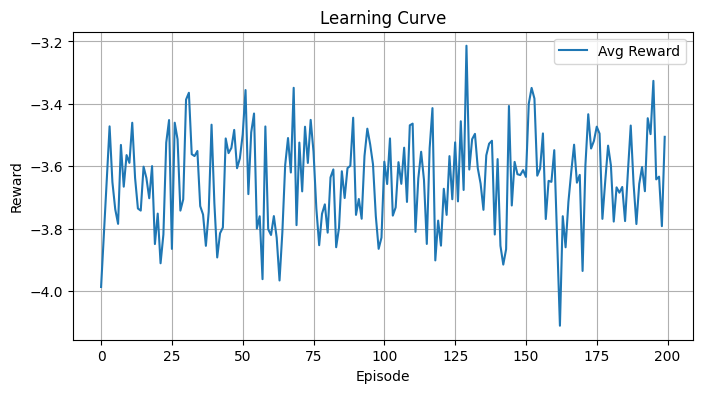

=== TRAINING PERFORMANCE METRICS ===


,Metric,Value
0,final_reward,-3.578201
1,initial_reward,-3.685086
2,total_improvement,0.106885
3,improvement_percentage,2.900467
4,convergence_episode,17.000000
5,convergence_rate,0.006287
6,stability_score,0.958554
7,variance_reduction,1.054402
8,learning_efficiency,0.488889
9,sample_efficiency,0.000534


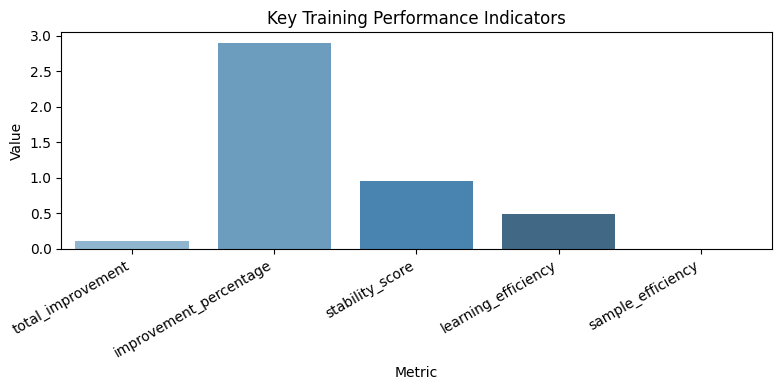

In [87]:
print("\n=== Training Metrics ===")
for k, v in results['training'].items():
    print(f"{k}: {v:.3f}")

  #Plot learning curve
plt.figure(figsize=(8,4))
plt.plot(training_history['episode_rewards'], label='Avg Reward')
plt.xlabel('Episode'); plt.ylabel('Reward')
plt.title('Learning Curve')
plt.legend(); plt.grid(True)
plt.show()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Prepare DataFrame from results['training']
training_metrics = results['training']
df_train = pd.DataFrame.from_dict(training_metrics, orient='index', columns=['Value'])
df_train.index.name = 'Metric'
df_train.reset_index(inplace=True)

# 2. Display as a table
from IPython.display import display
print("=== TRAINING PERFORMANCE METRICS ===")
display(df_train)

# 3. Select key metrics to plot
#    We’ll visualize: total_improvement, improvement_percentage, stability_score, learning_efficiency, sample_efficiency
plot_metrics = [
    'total_improvement',
    'improvement_percentage',
    'stability_score',
    'learning_efficiency',
    'sample_efficiency'
]
df_plot = df_train[df_train['Metric'].isin(plot_metrics)]

# 4. Bar chart
plt.figure(figsize=(8,4))
sns.barplot(data=df_plot, x='Metric', y='Value', palette='Blues_d')
plt.xticks(rotation=30, ha='right')
plt.ylabel('Value')
plt.title('Key Training Performance Indicators')
plt.tight_layout()
plt.show()






**PRIVACY PRESERVATION ANALYSIS**


=== Privacy Metrics ===
total_budget_used: 906921.397
avg_budget_per_agent: 181384.279
budget_distribution_fairness: 1.000
membership_inference_resistance: 0.507
model_inversion_resistance: 0.282
gradient_leakage_resistance: 0.031
overall_attack_resistance: 0.273
privacy_utility_tradeoff: 0.000


,Metric,Value
0,total_budget_used,906921.397404
1,avg_budget_per_agent,181384.279481
2,budget_distribution_fairness,1.000000
3,membership_inference_resistance,0.506667
4,model_inversion_resistance,0.282483
5,gradient_leakage_resistance,0.030635
6,overall_attack_resistance,0.273262
7,privacy_utility_tradeoff,0.000000


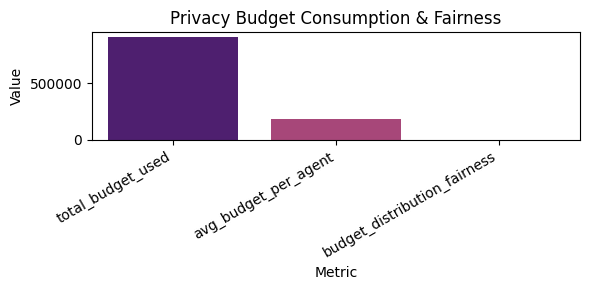

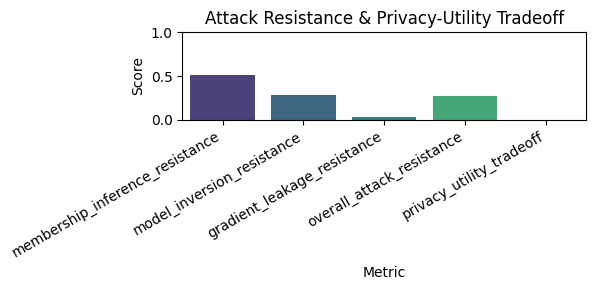

In [89]:
print("\n=== Privacy Metrics ===")
for k, v in results['privacy'].items():
    print(f"{k}: {v:.3f}")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# 1. Build DataFrame from privacy results
privacy_metrics = results['privacy']
df_priv = pd.DataFrame.from_dict(privacy_metrics, orient='index', columns=['Value'])
df_priv.index.name = 'Metric'
df_priv.reset_index(inplace=True)

# 2. Display full privacy table

display(df_priv)

# 3. Plot budget & resistance scores separately

# a) Budget metrics
budget_metrics = ['total_budget_used', 'avg_budget_per_agent', 'budget_distribution_fairness']
df_budget = df_priv[df_priv['Metric'].isin(budget_metrics)]

plt.figure(figsize=(6,3))
sns.barplot(data=df_budget, x='Metric', y='Value', palette='magma')
plt.title('Privacy Budget Consumption & Fairness')
plt.ylabel('Value')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

# b) Attack resistance metrics
resistance_metrics = [
    'membership_inference_resistance',
    'model_inversion_resistance',
    'gradient_leakage_resistance',
    'overall_attack_resistance',
    'privacy_utility_tradeoff'
]
df_res = df_priv[df_priv['Metric'].isin(resistance_metrics)]

plt.figure(figsize=(6,3))
sns.barplot(data=df_res, x='Metric', y='Value', palette='viridis')
plt.title('Attack Resistance & Privacy-Utility Tradeoff')
plt.ylabel('Score')
plt.ylim(0,1)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()


**CONTINUOUS HIGH FREQUENCY BEHAVIORAL PATTERN AGENT ANALYSIS**


=== Continuous High Frequency Behavioral Pattern Agent Metrics  ===
avg_sensor_frequency: 4.100
frequency_consistency: -0.114
temporal_correlation_strength: nan
action_exploration_diversity: 0.253
state_action_coupling: 0.370
high_frequency_retention: 0.410
behavioral_stability: nan
adaptive_response: 0.370


,Metric,Value
0,avg_sensor_frequency,4.100000
1,frequency_consistency,-0.113553
2,temporal_correlation_strength,NaN
3,action_exploration_diversity,0.253053
4,state_action_coupling,0.369739
5,high_frequency_retention,0.410000
6,behavioral_stability,NaN
7,adaptive_response,0.369739


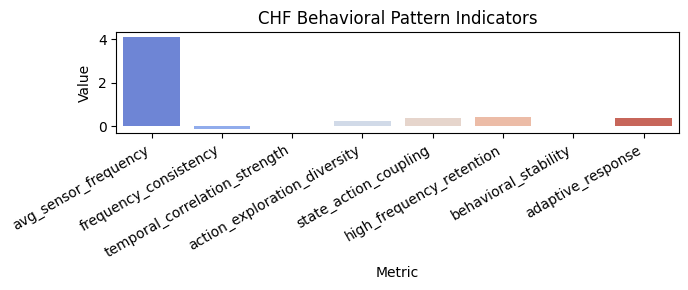

In [93]:
print("\n=== Continuous High Frequency Behavioral Pattern Agent Metrics  ===")
for k, v in results['behavioral'].items():
    print(f"{k}: {v:.3f}")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# 1. Prepare DataFrames
df_behavioral = pd.DataFrame.from_dict(
    results['behavioral'], orient='index', columns=['Value']
).reset_index().rename(columns={'index':'Metric'})
display(df_behavioral)
# 3. Plot Behavioral Metrics
plt.figure(figsize=(7,3))
sns.barplot(data=df_behavioral, x='Metric', y='Value', palette='coolwarm')
plt.title('CHF Behavioral Pattern Indicators')
plt.ylabel('Value')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

**RESOURCE UTILIZATION ANALYSIS**

total_parameters: 29945.000
avg_params_per_agent: 5989.000
param_efficiency: 0.893
model_memory_mb: 0.114
buffer_memory_mb: 1.526
total_memory_mb: 1.640
memory_efficiency: 0.998
avg_buffer_utilization: 1.000
buffer_balance: 1.000
overall_efficiency: 0.964


,Metric,Value
0,total_parameters,29945.000000
1,avg_params_per_agent,5989.000000
2,param_efficiency,0.893033
3,model_memory_mb,0.114231
4,buffer_memory_mb,1.525879
5,total_memory_mb,1.640110
6,memory_efficiency,0.998363
7,avg_buffer_utilization,1.000000
8,buffer_balance,1.000000
9,overall_efficiency,0.963798


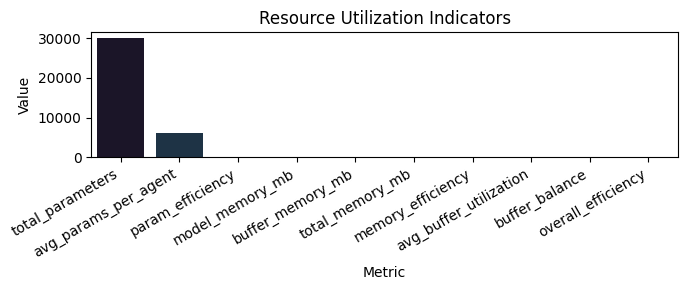

In [96]:
for k, v in results['resources'].items():
    print(f"{k}: {v:.3f}")
df_resources = pd.DataFrame.from_dict(
    results['resources'], orient='index', columns=['Value']
).reset_index().rename(columns={'index':'Metric'})
display(df_resources)
# 4. Plot Resource Metrics
plt.figure(figsize=(7,3))
sns.barplot(data=df_resources, x='Metric', y='Value', palette='cubehelix')
plt.title('Resource Utilization Indicators')
plt.ylabel('Value')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

**ATTACK RESISTANCE ANALYSIS**


=== ATTACK RESISTANCE ANALYSIS ===
Overall Robustness Score: 0.403

Scenario: low_noise
  mi_resistance: 0.500
  inv_resistance: 0.455
  grad_resistance: 0.033
  overall_resistance: 0.329

Scenario: medium_noise
  mi_resistance: 0.527
  inv_resistance: 0.937
  grad_resistance: 0.034
  overall_resistance: 0.499

Scenario: high_noise
  mi_resistance: 0.560
  inv_resistance: 0.555
  grad_resistance: 0.031
  overall_resistance: 0.382
robustness_score: 0.403


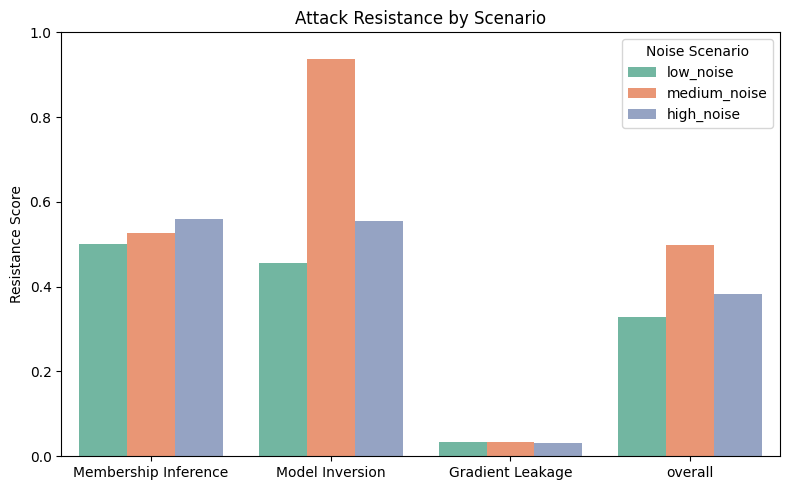

Overall Robustness Score: 0.403



Scenario,high_noise,low_noise,medium_noise
Attack Type,,,
Gradient Leakage,0.030573,0.032738,0.033557
Membership Inference,0.560000,0.500000,0.526667
Model Inversion,0.554808,0.455173,0.937250
overall,0.381794,0.329304,0.499158


In [86]:
print("\n=== ATTACK RESISTANCE ANALYSIS ===")
attack_res = results['attack_resistance']

# If there’s a high-level robustness score:
if 'robustness_score' in attack_res:
    print(f"Overall Robustness Score: {attack_res['robustness_score']:.3f}")

# Scenario-specific results:
if 'scenario_analysis' in attack_res:
    for scenario, metrics in attack_res['scenario_analysis'].items():
        print(f"\nScenario: {scenario}")
        for m_key, m_val in metrics.items():
            print(f"  {m_key}: {m_val:.3f}")

# If there are any other flat keys:
for k, v in attack_res.items():
    if k != 'scenario_analysis':
        # robustness_score already printed, skip nested dicts
        if not isinstance(v, dict):
            print(f"{k}: {v:.3f}")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assume `results` is available from run_complete_chf_evaluation()
attack_res = results['attack_resistance']

# 1. Build a DataFrame for scenario analysis
scenario_data = []
for scenario, metrics in attack_res['scenario_analysis'].items():
    for attack_type, score in metrics.items():
        scenario_data.append({
            'Scenario': scenario,
            'Attack Type': attack_type.replace('_resistance','').replace('mi','Membership Inference')
                                        .replace('inv','Model Inversion')
                                        .replace('grad','Gradient Leakage'),
            'Resistance Score': score
        })
df_scenarios = pd.DataFrame(scenario_data)

# 2. Plot grouped bar chart
plt.figure(figsize=(8,5))
sns.barplot(
    data=df_scenarios,
    x='Attack Type', y='Resistance Score',
    hue='Scenario', palette='Set2'
)
plt.ylim(0,1)
plt.title('Attack Resistance by Scenario')
plt.ylabel('Resistance Score')
plt.xlabel('')
plt.legend(title='Noise Scenario')
plt.tight_layout()
plt.show()

# 3. Show overall robustness score as a separate number
print(f"Overall Robustness Score: {attack_res['robustness_score']:.3f}\n")

# 4. Display the DataFrame as a table
from IPython.display import display
display(df_scenarios.pivot(index='Attack Type', columns='Scenario', values='Resistance Score'))

